# Deep Convolutional Neural Network for Art Classification with PyTorch
# Part 4: CNN

## Imports

In [6]:
# pip install --upgrade torch torchvision

In [7]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import PIL
from PIL import Image
import cv2
import pathlib
import glob
from pathlib import Path
import numpy as np
import shutil
import random
import pandas as pd
import argparse
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from platform import python_version
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("Python Version: ",python_version())

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
Python Version:  3.6.13


In [9]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
os.getcwd()

'/home/ec2-user/SageMaker/Masters-thesis/Classifier'

In [11]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [12]:
project_name='CNN_classifier'

## Data Exploration

In [13]:
def remove_folder(dir_path):
    for i in range(len(os.listdir(dir_path))):
        if os.listdir(dir_path)[i] == ' .ipynb_checkpoints':
            shutil.rmtree(os.path.join(dir_path,' .ipynb_checkpoints'))
        else: 
            pass

In [15]:
# strating with blank resized images
# data_dir = Path("/home/ec2-user/SageMaker/wikiart_binary")
data_dir = os.path.join("/home/ec2-user/SageMaker/wikiart_binary")

print(os.listdir(data_dir))

classes = os.listdir(data_dir + "/train")
remove_folder(os.path.join(data_dir,'train'))
remove_folder(os.path.join(data_dir,'test'))
# shutil.rmtree(os.path.join(data_dir,'train','.ipynb_checkpoints'))
# shutil.rmtree(os.path.join(data_dir,'test','.ipynb_checkpoints'))

print(classes)

['.ipynb_checkpoints', 'test', 'train']
['pre_1910s', 'post_1910s']


In [16]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


In [17]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0.9725, 0.9686, 0.9647,  ..., 1.0000, 0.9647, 0.9725],
         [0.9686, 0.9725, 0.9686,  ..., 1.0000, 0.9686, 0.9765],
         [0.9686, 0.9647, 0.9647,  ..., 1.0000, 0.9686, 0.9725],
         ...,
         [0.9843, 0.9843, 0.9804,  ..., 0.0118, 1.0000, 0.9647],
         [0.9843, 0.9843, 0.9804,  ..., 0.0471, 1.0000, 0.9686],
         [0.9843, 0.9843, 0.9804,  ..., 0.0275, 1.0000, 0.9961]],

        [[0.9686, 0.9686, 0.9725,  ..., 0.9961, 0.9647, 0.9725],
         [0.9686, 0.9725, 0.9686,  ..., 0.9961, 0.9686, 0.9765],
         [0.9686, 0.9647, 0.9647,  ..., 1.0000, 0.9686, 0.9725],
         ...,
         [0.9843, 0.9843, 0.9804,  ..., 0.0078, 1.0000, 0.9647],
         [0.9843, 0.9843, 0.9804,  ..., 0.0314, 1.0000, 0.9686],
         [0.9843, 0.9843, 0.9804,  ..., 0.0118, 1.0000, 1.0000]],

        [[0.9608, 0.9608, 0.9608,  ..., 0.9804, 0.9569, 0.9647],
         [0.9608, 0.9647, 0.9608,  ..., 0.9804, 0.9608, 0.9686],
         [0.9608, 0.9569, 0.9569,  ..., 0.9843, 0.9608, 0.

In [18]:
print(dataset.classes)

['post_1910s', 'pre_1910s']


In [19]:
len(dataset.classes)

2

In [20]:
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [21]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  post_1910s (0)


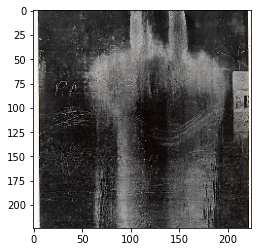

In [22]:
show_example(*dataset[0])

Label:  post_1910s (0)


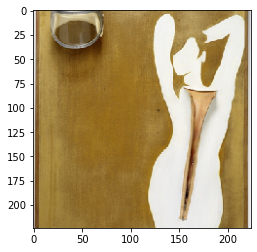

In [23]:
show_example(*dataset[3250])

## Training and Validation datasets

In [24]:
random_seed = 42
torch.manual_seed(random_seed);

In [25]:
val_size = 500
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(37129, 500)

In [26]:
from torch.utils.data.dataloader import DataLoader

batch_size= 16

In [27]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [28]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

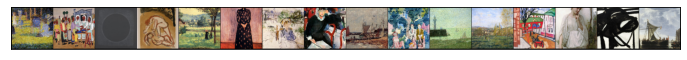

In [29]:
show_batch(train_dl)

In [30]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        torch.save(model.state_dict(), 'wikiart-cnn.pth')
        history.append(result)
    return history

# Defining the Convolutional Neural Network 

In [32]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
# data_dir = "wikiart_binary"
data_dir = Path("/home/ec2-user/SageMaker/wikiart_binary")

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, efficientnet, wide_resnet, regnet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 300

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    df = pd.DataFrame(columns=['Epoch','Phase','Loss','Accuracy'])
    since = time.time()

    test_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
#                         outputs, aux_outputs = model(inputs.float())
#                         loss1 = criterion(outputs, labels.unsqueeze(1))
#                         loss2 = criterion(aux_outputs, labels.unsqueeze(1))
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
#                         outputs = model(inputs.float())
                        loss = criterion(outputs, labels)
#                         loss = criterion(outputs, labels.unsqueeze(1))

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            df = df.append({'Epoch':epoch,'Phase':phase,'Loss':epoch_loss,'Accuracy':epoch_acc},ignore_index=True)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, test_acc_history

In [34]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [35]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet161(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "wide_resnet":
        """ Wide Resnet50 2
        """
        model_ft = models.wide_resnet50_2(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "regnet":
        """ Regnet y16gf
        """
        model_ft = models.regnet_y_16gf(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "resnext":
        """ Resnext 50
        """
        model_ft = models.resnext50_32x4d(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "vit":
        """ vit l16
        """
        model_ft = models.vit_l_16(pretrained=use_pretrained, progress = True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    elif model_name == "efficientnet":
        """ Efficientnet
        """
#         model_ft = EfficientNet.from_name('efficientnet-b5')
#         for param in model_ft.parameters():
#             param.requires_grad = True
#         num_ftrs = model_ft._fc.in_features
#         model_ft._fc = nn.Linear(num_ftrs, 1)
        model_ft = models.efficientnet_b5(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
#         num_ftrs = model_ft.classifier.in_features
#         model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [36]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [37]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized (maybe try Adam)
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)
# optimizer_ft = optim.Adam(params_to_update, lr=0.0005)



Params to learn:
	 fc.weight
	 fc.bias


In [39]:
# Setup the loss fxn for multi-class
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

### need to do a loop so if the output is post --> re run for post otherwise re run for pre 

In [40]:
name = "wikiart-cropped-post-resnet50-300epochs.pth"

In [41]:
saving_dir = Path("/home/ec2-user/SageMaker/models/",name)

In [ ]:
torch.save(model_ft.state_dict(), saving_dir)

In [44]:
# model = models.vgg11_bn(pretrained=True)
# model = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# model_ft.load_state_dict(torch.load('wikiart-cropped-binary.pth'))
model_ft.load_state_dict(torch.load(saving_dir))

In [ ]:
import torch, torchvision.models
model = torchvision.models.vgg11_bn()
path = 'wikiart-cropped-pre.pth'

In [ ]:
torch.save(model.state_dict(), path) # nothing else here
model.load_state_dict(torch.load(path))

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.001)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
hist


# Plots and verifications

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(hist)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
data_dir

In [ ]:
import torch

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
#     xb = torch.from_numpy(img).to(DEVICE).unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]


In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))


In [ ]:
img, label = test_dataset[10500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))



In [ ]:
img, label = test_dataset[148]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_ft))


In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
torch.save(model.state_dict(), 'wikiart-cnn.pth')



In [ ]:
model2 = to_device(Wikiart(), device)



# Import model n°2

In [ ]:
# model_binary = Net()
# model_binary.load_state_dict(torch.load("wikiart-cropped-binary.pth"))
model_binary = torch.load_state_dict("wikiart-cropped-binary.pth")
model_binary.eval()

In [ ]:
model_ft = torch.load("wikiart-cropped-binary.pth")

In [ ]:
model_ft.eval()

In [ ]:
model = model_ft()

In [ ]:
import torch
import torchvision.models as models

In [ ]:
# model = models.vgg11_bn(nn.Module) # we do not specify pretrained=True, i.e. do not load default weights
# model = models.vgg11_bn(nn.Module,pretrained=False)
# model.load_state_dict(torch.load('wikiart-cropped-binary.pth'))
model = model_ft.load_state_dict(torch.load('wikiart-cropped-binary.pth'))


In [ ]:
model = model_ft
model.load_state_dict(torch.load('wikiart-cropped-post.pth'))

In [ ]:
model.eval()

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

In [ ]:
model.eval()

In [ ]:
tnet = Tripletnet(model_ft).cuda()
tnet.load_state_dict(state_dict)
tnet.eval()

In [ ]:
model

In [ ]:
model.eval()

In [ ]:
model.vgg.load_state_dict('wikiart-cropped-binary.pth')